In [95]:
%matplotlib widget

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import sys

from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV

In [97]:
names=["TestID", "fuzzingOperationTimes", "staticCollision", "dynamicCollision", "cellTime", "FuzzingOpCount"]

In [98]:
res_col_subset=["fuzzingOperationTimes", "staticCollision", "dynamicCollision"]

In [99]:
# https://stackoverflow.com/questions/68522283/removing-dominated-rows-from-a-pandas-dataframe-rows-with-all-values-lower-th
def get_dominants(df):
    seen = [] # keep track of tested rows
    idx = df.index # initial index
    for i in range(len(df)+1):
        x = idx[0]
        if x in seen:   # done a full loop
            return df.loc[idx]
        seen.append(idx[0])
        # check which rows are dominated and drop them from the index
        idx = (df.loc[idx]-df.loc[x]).le(0).all(axis=1)
        # put tested row at the end
        idx = list(idx[~idx].index)+[x]

def dominant_subset_cols(df):
    return get_dominants(df[res_col_subset])

In [100]:
def dataframe_chosen_cols_to_csv(df, csv_file):
    subset_df = df[res_col_subset].copy()
    subset_df.to_csv(csv_file, index=False, header=False)

In [93]:
condbased_res960 = pd.read_csv("steppingcell-condbased-tts-cutdown", delim_whitespace=True)
condbased_res240 = pd.read_csv("tts-history-condfuzz-240", delim_whitespace=True)
condbased_res480 = pd.read_csv("tts-history-condfuzz-480", delim_whitespace=True)
condbased_res720 = pd.read_csv("tts-history-condfuzz-720", delim_whitespace=True)
dcondbased_240 = dominant_subset_cols(condbased_res240)
dcondbased_480 = dominant_subset_cols(condbased_res480)
dcondbased_720 = dominant_subset_cols(condbased_res720)
dcondbased_960 = dominant_subset_cols(condbased_res960)

In [115]:
dataframe_chosen_cols_to_csv(dcondbased_240, "condbased_history240.pf")
dataframe_chosen_cols_to_csv(dcondbased_480, "condbased_history480.pf")
dataframe_chosen_cols_to_csv(dcondbased_720, "condbased_history720.pf")
dataframe_chosen_cols_to_csv(dcondbased_960, "condbased_res960.pf")

In [102]:
def plot_3d_resultset(df, df2, graph_title, savefigFilename,xrot,yrot):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')    
    ax.view_init(xrot,yrot)
    ax.scatter(df["staticCollision"], df["dynamicCollision"], abs(df["fuzzingOperationTimes"]))
    
    if not (df2 is None):
        ax.scatter(df2["staticCollision"], df2["dynamicCollision"], abs(df2["fuzzingOperationTimes"]), color="green")

    ax.set_xlabel("Static collision metric")
    ax.set_ylabel("Dynamic collision metric")
    ax.set_zlabel("Fuzzing Operation Times")
    ax.set_title(graph_title)
    plt.tight_layout()
    plt.savefig(savefigFilename)
    plt.show()

In [103]:
def plot_3d_resultset_history_as_subplots(frontDFAttribs, graph_title, savefigFilename, xmax, ymax, zmax):
    labelfont = 8
    titlesize = 10 
    xwidth = 2
    
    vx = 16
    vy = -70
    
    xp = xwidth
    yp = int(len(frontDFAttribs) / xwidth)
    fig = plt.figure()
    default_alpha = 1.0
    
    ai = 1
    for itercount in frontDFAttribs:
        info = frontDFAttribs[itercount]
        df = info["front"]
        col = info["col"]
        title = info["title"]
        ax = fig.add_subplot(xp, yp, ai, projection="3d") 
        ax.scatter(df["staticCollision"], df["dynamicCollision"], df["fuzzingOperationTimes"], c=col, alpha=default_alpha)
        
        ax.view_init(vx,vy)
        ax.set_xlim(0, xmax)
        ax.set_ylim(0, ymax)
        ax.set_zlim(0, zmax)
        ax.set_title(title)
        ax.set_xlabel("Static collision", fontsize=labelfont)
        ax.set_ylabel("Dynamic collision", fontsize=labelfont)
        ax.set_zlabel("Total Fuzzing \nOperation Times", fontsize=labelfont)
        
        ai += 1

    plt.suptitle(graph_title)
    plt.tight_layout(pad=0.05)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.85, wspace=0.4, hspace=0.55)
    plt.savefig(savefigFilename)
    plt.show()

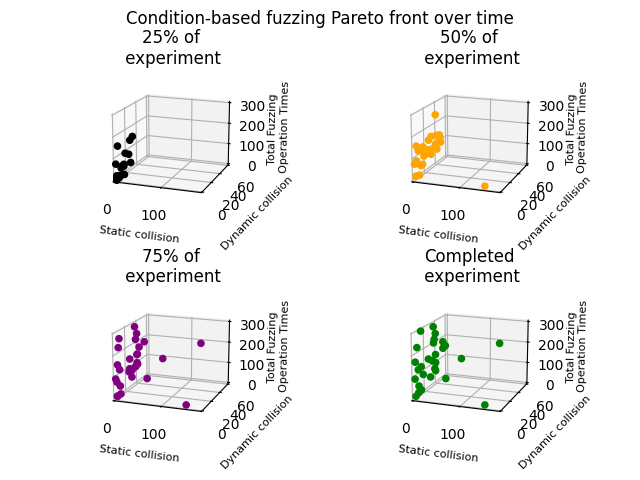

In [108]:
res_df_attribs = {"black": condbased_res240, 
                    "orange":condbased_res480, 
                    "purple": condbased_res720, 
                    "green": condbased_res960 }

res_df_attribs = {240 : {'front' : condbased_res240, 'col':"black",  'title': "25% of\n experiment"},
                  480 : {'front' : condbased_res480, 'col':"orange", 'title': "50% of\n experiment"}, 
                  720 : {'front' : condbased_res720, 'col':"purple", 'title': "75% of\n experiment"},
                  960 : {'front':  condbased_res960, 'col':"green", 'title': "Completed\n experiment"}}

#res_df_attribs = {240 : {'front' : condbased_res240, 'col':"black",  'title': "25% of\n experiment"},
#                  480 : {'front' : dcondbased_480, 'col':"orange", 'title': "50% of\n experiment"}, 
#                  720 : {'front' : dcondbased_720, 'col':"purple", 'title': "75% of\n experiment"},
#                  960 : {'front' : dcondbased_960, 'col':"green", 'title': "Completed\n experiment"}}

xmax = 180
ymax = 60
zmax = 300
                    
plot_3d_resultset_history_as_subplots(res_df_attribs, "Condition-based fuzzing Pareto front over time", "rq3-tts-3dfront-history.pdf", xmax, ymax, zmax)

In [109]:
dcondbased = dominant_subset_cols(condbased_res)
plot_3d_resultset(dtimebased, dcondbased, "Condition-based fuzzing and\n time-based Pareto front comparison", "rq2-condbased-tts-3d-pareto.pdf", 25, 70)

NameError: name 'condbased_res' is not defined

In [111]:
def max_point_from_front(pf):
    return np.array([np.max(pf.fuzzingOperationTimes), np.max(pf.staticCollision), np.max(pf.dynamicCollision)])

In [112]:
def max_point_all_fronts(pf_list):
    max_points_2d = np.column_stack(list(map(lambda pf: max_point_from_front(pf), pf_list)))
    max_of_all = np.amax(max_points_2d, axis=1)
    return max_of_all

In [113]:
def indicators_for_intermediate_fronts(front_info):
    # Reference point is obtained as the max point from all fronts
    ref_point = max_point_all_fronts([condbased_res240, condbased_res480, condbased_res720, condbased_res960])
    ref_front = np.loadtxt(open("condbased_res1000.pf", "rb"), delimiter=",")
    print("Ref point=" + str(ref_point))
    
    for pf_file in front_info:
        front = np.loadtxt(open(pf_file, "rb"), delimiter=",")
        front_attribs = front_info[pf_file]
        hv_ind = HV(ref_point=ref_point)
        igd_ind = IGD(front)
        hv_val = hv_ind(front)
        igd_val = igd_ind(ref_front)
        front_attribs['HV'] = hv_val
        front_attribs['IGD'] = igd_val

In [116]:
front_info = {'condbased_history240.pf' : {}, 
              'condbased_history480.pf' : {}, 
              'condbased_history720.pf' : {},
              'condbased_res960.pf' : {}}

indicators_for_intermediate_fronts(front_info)
front_info

Ref point=[316.8 180.   52. ]


{'condbased_history240.pf': {'HV': 1991477.2200000004,
  'IGD': 37.25648495341673},
 'condbased_history480.pf': {'HV': 1753549.4, 'IGD': 38.311338185143505},
 'condbased_history720.pf': {'HV': 1416564.4400000002,
  'IGD': 2.3903778467012295},
 'condbased_res960.pf': {'HV': 1349703.4800000002, 'IGD': 0.0}}

In [81]:
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
timebased_times = timebased_res["fuzzOpTimes"]

bins = np.linspace(0, 1000, 30)
plt.hist(timebased_times, bins, alpha=0.5, label='Timebased')
plt.title("Distribution of fuzzing times for both time-based and condition-based")
plt.legend(loc='upper right')
plt.show()


NameError: name 'timebased_res' is not defined

In [ ]:
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
condbased_times = timebased_res["fuzzOpTimes"]

bins = np.linspace(0, 1000, 30)
plt.hist(condbased_times, bins, alpha=0.5, label='Timebased')
plt.title("Distribution of fuzzing times for both time-based and condition-based")
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
timebased_times = timebased_res["fuzzOpTimes"]
condbased_times = condbased_res["fuzzOpTimes"]

bins = np.linspace(0, 1000, 30)
plt.hist(timebased_times, bins, alpha=0.5, label='Timebased')
plt.hist(condbased_times, bins, alpha=0.5, label='Condition-based')
plt.title("Distribution of total fuzzing times in the final front for both time-based and condition-based")
plt.legend(loc='upper right')
plt.show()


In [ ]:
fig, axes = plt.subplots(2, 1)
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
timebased_times = timebased_res["fuzzOpTimes"]
condbased_times = condbased_res["fuzzOpTimes"]

plt.suptitle("Distribution of fuzzing times for\n both time-based and condition-based variants")
bins = np.linspace(0, 600, 20)
axes[0].hist(timebased_times, bins, alpha=1.0, label='Time-based')
axes[0].legend(loc='upper right')
#axes[0].set(xlabel="Total fuzzing operation time (s)")

axes[1].hist(condbased_times, bins, alpha=1.0, color="green", label='Condition-based')
axes[1].legend(loc='upper right')
axes[1].set(xlabel="Total fuzzing operation time (s)")
plt.savefig("rq2-fuzzing-times.pdf")
plt.show()


In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
a / b

In [ ]:
def get_metric_time_ratios(res_df, metric_dfname):
    metric_time_ratio = res_df[metric_dfname] / res_df["fuzzOpTimes"]
    return metric_time_ratio

In [ ]:
timebased_ratios_human = get_metric_time_ratios(timebased_res, "uvExcessHuman")
condbased_ratios_human = get_metric_time_ratios(condbased_res, "uvExcessHuman")
timebased_ratios_surface = get_metric_time_ratios(timebased_res, "uvMissSurface")
condbased_ratios_surface = get_metric_time_ratios(condbased_res, "uvMissSurface")

In [ ]:
def plot_relative_ratios(timebased_ratio, timebased_label, condbased_ratio, condbased_label, xlabel, xmax, fig_filename):
    fig, axes = plt.subplots(2, 1)
    # Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing

    plt.suptitle("Distribution of fuzzing metric ratios\n for both time-based and condition-based variants")
    bins = np.linspace(0, xmax, 20)
    axes[0].hist(timebased_ratio, bins, alpha=1.0, label=timebased_label)
    axes[0].legend(loc='upper right')

    axes[1].hist(condbased_ratio, bins, alpha=1.0, color="green", label=condbased_label)
    axes[1].legend(loc='upper right')
    axes[1].set(xlabel=xlabel)
    plt.savefig(fig_filename)
    plt.show()

In [ ]:
timebased_ratios_human

In [ ]:
plot_relative_ratios(timebased_ratios_human, "Time-based fuzzing", condbased_ratios_human, "Condition-based fuzzing", "Human metric ratio per time", 0.2, "rq2_human_metric_ratio.pdf")


In [ ]:
plot_relative_ratios(timebased_ratios_surface, "Time-based fuzzing", condbased_ratios_surface, "Condition-based fuzzing", "Human metric ratio per time", 0.2, "rq2_human_metric_ratio.pdf")